In [19]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import tensorflow.compat.v1 as tf
import random

tf.disable_v2_behavior()
print("Num GPUs Available: ", tf.test.is_built_with_cuda())

path="../../data"
IMG_SIZE=100

Num GPUs Available:  False


In [20]:
dog_files=os.listdir(path+'/dogs')
wolf_files=os.listdir(path+'/wolves')
image_paths = []
#label: 0 for dog ,1 for wolf # woof -woof
labels=[]
img=[]
for file in dog_files:
    image = cv2.imread(path+'/'+'dogs/'+file)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    norm_image = image/255.0 
    # Creating and saving each image in the form of numerical data in an array
    img.append(image.flatten())
    labels.append([1,0])
    image_paths.append(path+'/'+'dogs/'+file)
for file in wolf_files:
    image = cv2.imread(path+'/'+'wolves/'+file)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    norm_image = image/255.0 
          #Creating and saving each image in the form of numerical data in an array
    image_paths.append(path+'/'+'wolves/'+file)

    img.append(image.flatten())
    labels.append([0,1])

In [21]:
df={'data':img,'label':labels}
df=pd.DataFrame(df)
df = df.sample(frac=1).reset_index(drop=True)

[1, 0]


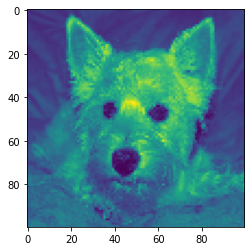

In [22]:
plt.imshow(df.data[0].reshape(IMG_SIZE,IMG_SIZE))
print(df.label[1])
#main_train_df,test_df=train_test_split(df, test_size=0.2,shuffle=True,random_state=42)
#train_df,val_df=train_test_split(main_train_df, test_size=0.1,shuffle=True,random_state=42)
#random.shuffle(df)
train_df=df[:1400]
val_df=df[1400:1600]
test_df=df[1600:]


In [ ]:
def getData(dataset):
    img = []
    label = []
    for x, y in dataset:
        img.append(x)
        label.append(y)
    return img,label

In [23]:
x_train=list(train_df.data)
y_train=list(train_df.label)
x_val=list(val_df.data)
y_val=list(val_df.label)
x_test=list(test_df.data)
y_test=list(test_df.label)

In [24]:
X=tf.placeholder(tf.float32,[None,IMG_SIZE*IMG_SIZE])
Y=tf.placeholder(tf.float32,[None,2])
W=tf.Variable(tf.zeros([IMG_SIZE*IMG_SIZE,2]))
b=tf.Variable(tf.zeros([2]))
eps = 1e-12

In [36]:

h =tf.matmul(X,W)+b#1 / (1.0 + tf.exp(-(tf.matmul(img,W) + b)))
# softmax
actv = tf.nn.sigmoid(h)
# cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred), reduction_indices=1))
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
prediction = tf.argmax(actv,1)
correct_prediction = tf.equal(prediction, tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# loss1 = -(Y * tf.log(h + eps) + (1 - Y) * tf.log( 1 - h + eps))
loss1=tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=h)
loss = tf.reduce_mean(loss1)
# loss = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(actv), reduction_indices=1)) 
# loss = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred), reduction_indices=1)) 
alpha = 0.00000001
update = tf.train.GradientDescentOptimizer(alpha).minimize(loss)

loss_data = []


In [53]:
batch_size = 140
num_batches = int(len(x_train)/batch_size)

def getBatch(data,d_label,curr_index,batch_size):
    return data[curr_index:curr_index+batch_size],d_label[curr_index:curr_index+batch_size]


In [54]:
arr=np.linspace(0.00000001,0.0000001,num=50)

In [66]:
# arr =[alpha,alpha+alpha/2]
max_acc = []
max_acc_v = []
alphas = [] 
for j in range(0,len(arr)):
    ac=[]
    ac_v=[]
    print(f"shitttttttt {arr[j]}")
    update = tf.train.GradientDescentOptimizer(arr[j]).minimize(loss)
    sess=tf.Session()
    sess.run(tf.global_variables_initializer())
    curr_index = 0 
    for i in range(0,num_batches):
        batch_x,batch_y = getBatch(x_train,y_train,i,batch_size)
        if i%7==0:
            loss_data.append(loss.eval(session= sess, feed_dict = {X:batch_x,Y:batch_y}))
            train_acc,train_loss = sess.run([accuracy,loss], feed_dict={X:batch_x,Y:batch_y})
            print (" Training accuracy: %.10f, Training loss: %.10f" % (train_acc, train_loss))
            val_acc,val_loss = sess.run([accuracy,loss], feed_dict={X:x_val,Y:y_val})
            ac_v.append(float(val_acc))
            ac.append(float(train_acc))
            print (" Validation accuracy: %.10f, Validation loss: %.10f" % (val_acc,val_loss))
        sess.run([update],feed_dict={X:batch_x,Y:batch_y})
    # max_acc.append(np.max(ac))
    alphas.append(float(arr[j]))
    max_acc_v.append(np.max(ac_v)) 
    max_acc.append(np.max(ac))
# print(loss_data)
print(max_acc_v)

shitttttttt 1e-08
 Training accuracy: 0.5285714269, Training loss: 0.6931473613
 Validation accuracy: 0.5249999762, Validation loss: 0.6931474209
 Training accuracy: 0.5285714269, Training loss: 0.6855505705
 Validation accuracy: 0.5249999762, Validation loss: 0.6898221374
shitttttttt 1.1836734693877552e-08
 Training accuracy: 0.5285714269, Training loss: 0.6931473613
 Validation accuracy: 0.5249999762, Validation loss: 0.6931474209
 Training accuracy: 0.5285714269, Training loss: 0.6846843362
 Validation accuracy: 0.5249999762, Validation loss: 0.6895747185
shitttttttt 1.3673469387755102e-08
 Training accuracy: 0.5285714269, Training loss: 0.6931473613
 Validation accuracy: 0.5249999762, Validation loss: 0.6931474209
 Training accuracy: 0.5285714269, Training loss: 0.6838718057
 Validation accuracy: 0.5249999762, Validation loss: 0.6893479824
shitttttttt 1.551020408163265e-08
 Training accuracy: 0.5285714269, Training loss: 0.6931473613
 Validation accuracy: 0.5249999762, Validation l

[1e-08, 1.1836734693877552e-08, 1.3673469387755102e-08, 1.551020408163265e-08, 1.7346938775510203e-08, 1.9183673469387755e-08, 2.1020408163265306e-08, 2.2857142857142858e-08, 2.469387755102041e-08, 2.6530612244897957e-08, 2.836734693877551e-08, 3.0204081632653064e-08, 3.2040816326530615e-08, 3.387755102040817e-08, 3.571428571428571e-08, 3.755102040816326e-08, 3.9387755102040815e-08, 4.122448979591836e-08, 4.306122448979591e-08, 4.489795918367346e-08, 4.6734693877551014e-08, 4.8571428571428566e-08, 5.040816326530612e-08, 5.224489795918367e-08, 5.408163265306122e-08, 5.591836734693877e-08, 5.7755102040816323e-08, 5.9591836734693875e-08, 6.142857142857143e-08, 6.326530612244898e-08, 6.510204081632653e-08, 6.693877551020408e-08, 6.877551020408163e-08, 7.061224489795917e-08, 7.244897959183672e-08, 7.428571428571427e-08, 7.612244897959183e-08, 7.795918367346938e-08, 7.979591836734693e-08, 8.163265306122448e-08, 8.346938775510203e-08, 8.530612244897958e-08, 8.714285714285713e-08, 8.8979591836

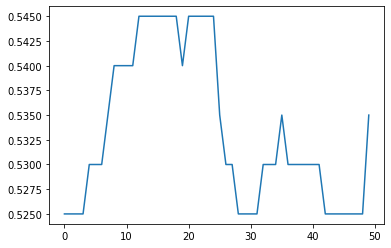

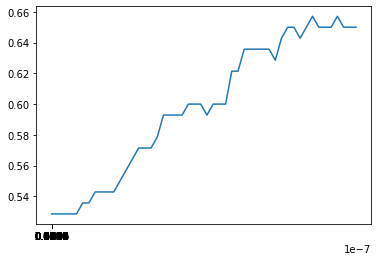

In [75]:
np.multiply(alphas,10000000000000)
print(alphas)
plt.plot(max_acc_v)
plt.show()
plt.plot(max_acc)
plt.xticks(alphas)
plt.show()

In [ ]:
def getBatch(data,d_label,curr_index,batch_size):
    return data[curr_index:curr_index+batch_size],d_label[curr_index:curr_index+batch_size]

In [ ]:
correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={X: x_val, Y: y_val}))

In [ ]:
plt.ylabel('loss')
plt.xlabel('iteration in 1000')
plt.plot(loss_data)


In [ ]:

print(sess.run(accuracy, feed_dict={X: x_val, Y: y_val}))

In [ ]:
k={'data':x,'label':labels}
type(np.array(k['data']))

In [ ]:
np.array(k['data'])

In [ ]:
numeric_dataset = tf.data.Dataset.from_tensor_slices((train_df.data, train_df.label))